In [1]:
import torch
import torchvision
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2
import copy

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
# split dataset
posA = "dataset/celeA_50"
posB = "dataset/flickr_50"
negA = "dataset/stylegan_50"
negB = "dataset/fake1000_50"

In [4]:
traindata = [os.path.join(posA,filename)for filename in os.listdir(posA)][:800] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][:800] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][:800] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][:800]
trainlabel = [1]*1600 + [0]*1600

validdata = [os.path.join(posA,filename)for filename in os.listdir(posA)][800:900] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][800:900] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][800:900] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][800:900]
validlabel = [1]*200 + [0]*200

testdata  = [os.path.join(posA,filename)for filename in os.listdir(posA)][900:] + \
            [os.path.join(posB,filename)for filename in os.listdir(posB)][900:] + \
            [os.path.join(negA,filename)for filename in os.listdir(negA)][900:] + \
            [os.path.join(negB,filename)for filename in os.listdir(negB)][900:]
testlabel = [1]*200 + [0]*200

len(traindata),len(validdata),len(testdata),len(trainlabel),len(validlabel),len(testlabel)

(3200, 400, 400, 3200, 400, 400)

In [5]:
def SRMConv(img):
    filter1 = np.array([[0,0,0,0,0],
                        [0,-1,2,-1,0],
                        [0,2,-4,2,0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]]) /4
    filter2 = np.array([[-1,2,-2,2,-1],
                        [2,-6,8,-6,2],
                        [-2,8,-12,8,-2],
                        [2,-6,8,-6,2],
                        [-1,2,-2,2,-1]]) / 12
    filter3 = np.array([[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-2,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]) / 2
    dst1 = np.sum(cv2.filter2D(img, cv2.CV_32F, filter1),axis=2)
    dst2 = np.sum(cv2.filter2D(img, cv2.CV_32F, filter2),axis=2)
    dst3 = np.sum(cv2.filter2D(img, cv2.CV_32F, filter3),axis=2)
    
    #noise = np.concatenate((dst1,dst2,dst3),axis=2)
    noise = np.dstack((dst1,dst2,dst3))
    return noise

In [6]:
class DeepfakeData(Dataset):
    def __init__(self, pathList, labelList, transform=None):
        self.pathList = pathList
        self.labelList = labelList
        self.transform = transform

    def __len__(self):
        return len(self.pathList)
    
    def __getitem__(self,index):
        
        img = cv2.imread(self.pathList[index])
        img = SRMConv(img)
        label = self.labelList[index]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label


In [7]:
transform = transforms.Compose([transforms.ToTensor()])
traindataset = DeepfakeData(traindata, trainlabel, transform)
validdataset = DeepfakeData(validdata, validlabel, transform)
testdataset = DeepfakeData(testdata, testlabel, transform)

In [8]:
batchsize = 4
trainloader = DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=4)
validloader = DataLoader(validdataset)
testloader = DataLoader(testdataset)

### train

In [9]:
net = torchvision.models.resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
net.cuda()
epoch_max = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
acc_max = 0
for epoch in range(epoch_max):
    loss_epoch = 0
    loss_count = 0
    net.train()
    for i, (img,label) in enumerate(trainloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()

        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss
        loss_count += 1
        
        if i*batchsize%400 == 0:
            print("Epoch:{} Loss:{} iter:{}".format(epoch, loss_epoch/loss_count, i*batchsize))
            loss_epoch = 0
            loss_count = 0
            
    
            
    loss_epoch = 0
    loss_count = 0
    predict = []
    expect = []
    net.eval()
    for i, (img,label) in enumerate(validloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()
        with torch.no_grad():
            output = net(img)
        loss = criterion(output, label)
        
        loss_epoch += loss
        loss_count += 1
        
        predict.append(np.argmax(output.cpu().numpy()))
        expect.append(label.cpu().numpy().item())
    acc = accuracy_score(expect, predict)
    pre = precision_score(expect, predict)
    rec = recall_score(expect, predict)
    
    if acc_max < acc:
        print("!")
        acc_max = acc
        best_model_wts = copy.deepcopy(net.state_dict())
        best_epoch = epoch
    
    print("EVALUATION\nEpoch:{} Loss:{} acc:{} precision:{} recall:{}".format(epoch, loss_epoch/loss_count, acc, pre, rec))
    print("##########################################################################")

/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch:0 Loss:0.5843858122825623 iter:0
Epoch:0 Loss:0.9816451668739319 iter:400
Epoch:0 Loss:0.7930801510810852 iter:800
Epoch:0 Loss:0.7610905170440674 iter:1200
Epoch:0 Loss:0.6336286067962646 iter:1600
Epoch:0 Loss:0.7041664719581604 iter:2000
Epoch:0 Loss:0.618208110332489 iter:2400
Epoch:0 Loss:0.6699737906455994 iter:2800


/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


!
EVALUATION
Epoch:0 Loss:1.2677816152572632 acc:0.525 precision:0.5128205128205128 recall:1.0
##########################################################################
Epoch:1 Loss:0.563809871673584 iter:0
Epoch:1 Loss:0.6941555738449097 iter:400
Epoch:1 Loss:0.4546736478805542 iter:800
Epoch:1 Loss:0.5117096304893494 iter:1200
Epoch:1 Loss:0.4684506952762604 iter:1600
Epoch:1 Loss:0.333732932806015 iter:2000
Epoch:1 Loss:0.4654144048690796 iter:2400
Epoch:1 Loss:0.5104777216911316 iter:2800
!
EVALUATION
Epoch:1 Loss:0.3813696503639221 acc:0.8125 precision:0.9032258064516129 recall:0.7
##########################################################################
Epoch:2 Loss:0.04543915390968323 iter:0
Epoch:2 Loss:0.30919304490089417 iter:400
Epoch:2 Loss:0.37594059109687805 iter:800
Epoch:2 Loss:0.3572354316711426 iter:1200
Epoch:2 Loss:0.32936611771583557 iter:1600
Epoch:2 Loss:0.38756683468818665 iter:2000
Epoch:2 Loss:0.39666107296943665 iter:2400
Epoch:2 Loss:0.2796342074871063 ite

Epoch:16 Loss:0.0011598259443417192 iter:2800
EVALUATION
Epoch:16 Loss:0.1637457311153412 acc:0.9425 precision:0.9447236180904522 recall:0.94
##########################################################################
Epoch:17 Loss:0.023897111415863037 iter:0
Epoch:17 Loss:0.004398392513394356 iter:400
Epoch:17 Loss:0.00319541129283607 iter:800
Epoch:17 Loss:0.0017478548688814044 iter:1200
Epoch:17 Loss:0.006509179249405861 iter:1600
Epoch:17 Loss:0.0025487157981842756 iter:2000
Epoch:17 Loss:0.0007930725696496665 iter:2400
Epoch:17 Loss:0.002830810844898224 iter:2800
EVALUATION
Epoch:17 Loss:0.161336287856102 acc:0.9375 precision:0.9032258064516129 recall:0.98
##########################################################################
Epoch:18 Loss:0.0004006028175354004 iter:0
Epoch:18 Loss:0.0009207987459376454 iter:400
Epoch:18 Loss:0.006173461675643921 iter:800
Epoch:18 Loss:0.014359197579324245 iter:1200
Epoch:18 Loss:0.002636558376252651 iter:1600
Epoch:18 Loss:0.007592254318296909

Epoch:32 Loss:0.0005352437146939337 iter:400
Epoch:32 Loss:0.000375022878870368 iter:800
Epoch:32 Loss:0.0008707037195563316 iter:1200
Epoch:32 Loss:0.0003565615334082395 iter:1600
Epoch:32 Loss:0.0006350722978822887 iter:2000
Epoch:32 Loss:0.0007277953554876149 iter:2400
Epoch:32 Loss:0.0007519274950027466 iter:2800
!
EVALUATION
Epoch:32 Loss:0.11329855024814606 acc:0.965 precision:0.9603960396039604 recall:0.97
##########################################################################
Epoch:33 Loss:4.7326087951660156e-05 iter:0
Epoch:33 Loss:0.0005542057915590703 iter:400
Epoch:33 Loss:0.0016672388883307576 iter:800
Epoch:33 Loss:0.0003349637845531106 iter:1200
Epoch:33 Loss:0.00020668446086347103 iter:1600
Epoch:33 Loss:0.00043484329944476485 iter:2000
Epoch:33 Loss:0.0005744811496697366 iter:2400
Epoch:33 Loss:0.00036103397724218667 iter:2800
EVALUATION
Epoch:33 Loss:0.13058775663375854 acc:0.955 precision:0.946078431372549 recall:0.965
#############################################

Epoch:47 Loss:0.00023792206775397062 iter:1600
Epoch:47 Loss:0.0001006841630442068 iter:2000
Epoch:47 Loss:0.00021555960120167583 iter:2400
Epoch:47 Loss:0.00022652625921182334 iter:2800
EVALUATION
Epoch:47 Loss:0.1445763111114502 acc:0.9475 precision:0.9408866995073891 recall:0.955
##########################################################################
Epoch:48 Loss:1.1920928955078125e-07 iter:0
Epoch:48 Loss:0.00011889278539456427 iter:400
Epoch:48 Loss:0.000263870955677703 iter:800
Epoch:48 Loss:8.378743950743228e-05 iter:1200
Epoch:48 Loss:9.418308763997629e-05 iter:1600
Epoch:48 Loss:0.0002166956546716392 iter:2000
Epoch:48 Loss:0.00018172382260672748 iter:2400
Epoch:48 Loss:0.0001735967380227521 iter:2800
EVALUATION
Epoch:48 Loss:0.1517270803451538 acc:0.945 precision:0.9320388349514563 recall:0.96
##########################################################################
Epoch:49 Loss:0.00010323524475097656 iter:0
Epoch:49 Loss:0.00016507327381987125 iter:400
Epoch:49 Loss:0.

In [11]:
torch.save(best_model_wts,"Noise_Compress50_Epoch{}_validAcc{}".format(best_epoch,acc_max))

In [12]:
net.load_state_dict(best_model_wts)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
epoch_max = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [14]:
acc_max = 0
for epoch in range(epoch_max):
    loss_epoch = 0
    loss_count = 0
    net.train()
    for i, (img,label) in enumerate(trainloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()

        optimizer.zero_grad()
        output = net(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss
        loss_count += 1
        
        if i*batchsize%400 == 0:
            print("Epoch:{} Loss:{} iter:{}".format(epoch, loss_epoch/loss_count, i*batchsize))
            loss_epoch = 0
            loss_count = 0
            
    
            
    loss_epoch = 0
    loss_count = 0
    predict = []
    expect = []
    net.eval()
    for i, (img,label) in enumerate(validloader):
        img = img.cuda()
        label = torch.tensor(label,dtype=torch.int64).cuda()
        with torch.no_grad():
            output = net(img)
        loss = criterion(output, label)
        
        loss_epoch += loss
        loss_count += 1
        
        predict.append(np.argmax(output.cpu().numpy()))
        expect.append(label.cpu().numpy().item())
    acc = accuracy_score(expect, predict)
    pre = precision_score(expect, predict)
    rec = recall_score(expect, predict)
    
    if acc_max < acc:
        print("!")
        acc_max = acc
        best_model_wts = copy.deepcopy(net.state_dict())
        best_epoch = epoch
    
    print("EVALUATION\nEpoch:{} Loss:{} acc:{} precision:{} recall:{}".format(epoch, loss_epoch/loss_count, acc, pre, rec))
    print("##########################################################################")

/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch:0 Loss:0.00031566619873046875 iter:0
Epoch:0 Loss:0.00025570092839188874 iter:400
Epoch:0 Loss:0.000405862316256389 iter:800
Epoch:0 Loss:0.00025829850346781313 iter:1200
Epoch:0 Loss:0.00025523005751892924 iter:1600
Epoch:0 Loss:0.00034987746039405465 iter:2000
Epoch:0 Loss:0.00040913998964242637 iter:2400
Epoch:0 Loss:0.0004038739134557545 iter:2800


/data/home/wws/environment/python3.5.2/local/lib/python3.5/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


!
EVALUATION
Epoch:0 Loss:0.12116298079490662 acc:0.9575 precision:0.9420289855072463 recall:0.975
##########################################################################
Epoch:1 Loss:7.486343383789062e-05 iter:0
Epoch:1 Loss:0.00027699946076609194 iter:400
Epoch:1 Loss:0.0003189682902302593 iter:800
Epoch:1 Loss:0.00022019266907591373 iter:1200
Epoch:1 Loss:0.00027844429132528603 iter:1600
Epoch:1 Loss:0.0003106874064542353 iter:2000
Epoch:1 Loss:0.0006670319708064198 iter:2400
Epoch:1 Loss:0.0004413336282595992 iter:2800
EVALUATION
Epoch:1 Loss:0.14678075909614563 acc:0.9375 precision:0.9032258064516129 recall:0.98
##########################################################################
Epoch:2 Loss:6.4373016357421875e-06 iter:0
Epoch:2 Loss:0.0005740845226682723 iter:400
Epoch:2 Loss:0.00036968410131521523 iter:800
Epoch:2 Loss:0.0002703207719605416 iter:1200
Epoch:2 Loss:0.0002884638379327953 iter:1600
Epoch:2 Loss:0.0002543747250456363 iter:2000
Epoch:2 Loss:0.000190126302186

Epoch:17 Loss:0.00029308436205610633 iter:800
Epoch:17 Loss:0.00033237694879062474 iter:1200
Epoch:17 Loss:0.00016356765991076827 iter:1600
Epoch:17 Loss:0.00018752097093965858 iter:2000
Epoch:17 Loss:0.001114506390877068 iter:2400
Epoch:17 Loss:0.00026826083194464445 iter:2800
EVALUATION
Epoch:17 Loss:0.1288585364818573 acc:0.955 precision:0.9375 recall:0.975
##########################################################################
Epoch:18 Loss:0.0007852315902709961 iter:0
Epoch:18 Loss:0.0003691130841616541 iter:400
Epoch:18 Loss:0.0002477240632288158 iter:800
Epoch:18 Loss:0.000690263812430203 iter:1200
Epoch:18 Loss:0.0003281837562099099 iter:1600
Epoch:18 Loss:0.00025528488913550973 iter:2000
Epoch:18 Loss:0.000368144508684054 iter:2400
Epoch:18 Loss:0.0004849117831327021 iter:2800
EVALUATION
Epoch:18 Loss:0.13768713176250458 acc:0.94 precision:0.9150943396226415 recall:0.97
##########################################################################
Epoch:19 Loss:8.94069671630859

Epoch:32 Loss:0.00036001444095745683 iter:2400
Epoch:32 Loss:0.0001609307510079816 iter:2800
EVALUATION
Epoch:32 Loss:0.1357354074716568 acc:0.9475 precision:0.9282296650717703 recall:0.97
##########################################################################
Epoch:33 Loss:3.075599670410156e-05 iter:0
Epoch:33 Loss:0.00021262347581796348 iter:400
Epoch:33 Loss:0.0002702295605558902 iter:800
Epoch:33 Loss:0.00020576536189764738 iter:1200
Epoch:33 Loss:0.0002392727037658915 iter:1600
Epoch:33 Loss:0.0007966863922774792 iter:2000
Epoch:33 Loss:0.0004742735472973436 iter:2400
Epoch:33 Loss:0.00024051546643022448 iter:2800
EVALUATION
Epoch:33 Loss:0.13921426236629486 acc:0.9475 precision:0.9543147208121827 recall:0.94
##########################################################################
Epoch:34 Loss:0.0006539821624755859 iter:0
Epoch:34 Loss:0.00011871993046952412 iter:400
Epoch:34 Loss:0.00024954555556178093 iter:800
Epoch:34 Loss:0.000347951048752293 iter:1200
Epoch:34 Loss:0.00

Epoch:48 Loss:5.8531761169433594e-05 iter:0
Epoch:48 Loss:0.00021537303109653294 iter:400
Epoch:48 Loss:0.0002800488437060267 iter:800
Epoch:48 Loss:0.0002888184681069106 iter:1200
Epoch:48 Loss:0.0001803064369596541 iter:1600
Epoch:48 Loss:0.00017884194676298648 iter:2000
Epoch:48 Loss:0.00025724709848873317 iter:2400
Epoch:48 Loss:0.00017556309467181563 iter:2800
EVALUATION
Epoch:48 Loss:0.14364935457706451 acc:0.945 precision:0.9198113207547169 recall:0.975
##########################################################################
Epoch:49 Loss:7.295608520507812e-05 iter:0
Epoch:49 Loss:0.0001563572877785191 iter:400
Epoch:49 Loss:0.00022948920377530158 iter:800
Epoch:49 Loss:0.00024826734443195164 iter:1200
Epoch:49 Loss:0.00041891515138559043 iter:1600
Epoch:49 Loss:8.121430437313393e-05 iter:2000
Epoch:49 Loss:0.0001844447833718732 iter:2400
Epoch:49 Loss:0.0003131777048110962 iter:2800
EVALUATION
Epoch:49 Loss:0.12677671015262604 acc:0.955 precision:0.946078431372549 recall:0.96

In [15]:
torch.save(best_model_wts,"Noise_Compress50_Finetuning_Epoch{}_validAcc{}".format(best_epoch,acc_max))

### Visualization

In [16]:
import resnet_cam
import cam_noise as cam
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
net = resnet_cam.resnet18(pretrained=False)
net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

In [18]:
net.load_state_dict(torch.load("Noise_Compress50_Epoch32_validAcc0.965"))
net.cuda()
_ = net.eval()

In [19]:
cam_drawer = cam.Drawer(net)

(2, 512, 1, 1)


In [20]:
predict = []
expect = []
for i in range(len(testdata)):
    imgPath = testdata[i]
    imgLabel = testlabel[i]
    pre_cls, raw_img, heatmap, _ = cam_drawer.get_heat_map(testdata[i],camtype=0)
    expect.append(imgLabel)
    predict.append(pre_cls)

In [21]:
acc = accuracy_score(expect, predict)
pre = precision_score(expect, predict)
rec = recall_score(expect, predict)
print("EVALUATION acc:{} precision:{} recall:{}".format(acc, pre, rec))

EVALUATION acc:0.9475 precision:0.9408866995073891 recall:0.955


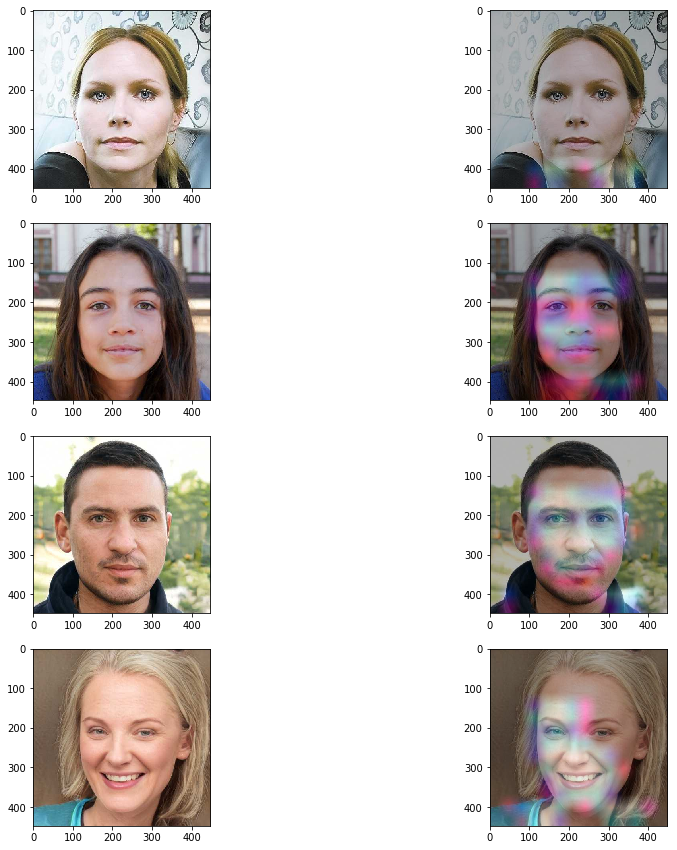

In [22]:
plt.figure(figsize=(15,15))

plt.subplot(421)
plt.imshow(cam_drawer.get_heat_map(testdata[1],camtype=0)[1])
plt.subplot(422)
plt.imshow(cam_drawer.get_heat_map(testdata[1],camtype=0)[2])

plt.subplot(423)
plt.imshow(cam_drawer.get_heat_map(testdata[101],camtype=0)[1])
plt.subplot(424)
plt.imshow(cam_drawer.get_heat_map(testdata[101],camtype=0)[2])

plt.subplot(425)
plt.imshow(cam_drawer.get_heat_map(testdata[201],camtype=0)[1])
plt.subplot(426)
plt.imshow(cam_drawer.get_heat_map(testdata[201],camtype=0)[2])

plt.subplot(427)
plt.imshow(cam_drawer.get_heat_map(testdata[301],camtype=0)[1])
plt.subplot(428)
plt.imshow(cam_drawer.get_heat_map(testdata[301],camtype=0)[2])

plt.show()

In [23]:
predict = []
expect = []
errorImg = []
errorCAM = []
errorGT = []
for i in range(len(validdata)):
    imgPath = validdata[i]
    imgLabel = validlabel[i]
    pre_cls, raw_img, heatmap, _ = cam_drawer.get_heat_map(validdata[i],camtype=0)
    expect.append(imgLabel)
    predict.append(pre_cls)
    
    if i in [204,246]:
        errorImg.append(raw_img)
        errorCAM.append(heatmap)
        errorGT.append(imgLabel)

In [24]:
acc = accuracy_score(expect, predict)
pre = precision_score(expect, predict)
rec = recall_score(expect, predict)
print("EVALUATION acc:{} precision:{} recall:{}".format(acc, pre, rec))

EVALUATION acc:0.965 precision:0.9603960396039604 recall:0.97


两张合成图像被判定为真实图像


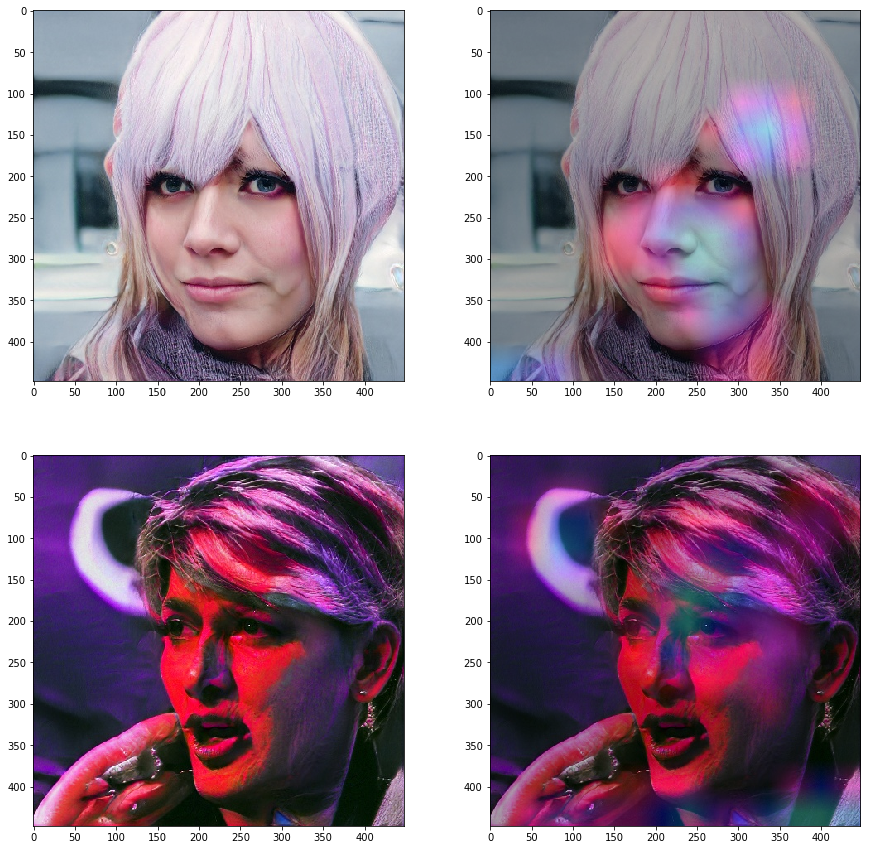

In [20]:
plt.figure(figsize=(15,15))
print("两张合成图像被判定为真实图像")

#print(errorGT[0])
plt.subplot(221)
plt.imshow(errorImg[0])
plt.subplot(222)
plt.imshow(errorCAM[0])

#print(errorGT[1])
plt.subplot(223)
plt.imshow(errorImg[1])
plt.subplot(224)
plt.imshow(errorCAM[1])

plt.show()